In [1]:
import numpy as np
import scipy.fftpack as sf
import scipy.linalg as lp
import pickle
import pywt
import matplotlib.pyplot as plt
import os

In [2]:
import scipy.stats
import scipy.signal as signal

### Load Data

In [3]:
data = np.zeros([32,40,40,8064])
labels = np.zeros([32,40,4])

for i in range(1, 33):
    if i < 10:
        file = "./data_preprocessed_python/s{0}.dat".format("0" + str(i))
    else:
        file = "./data_preprocessed_python/s{0}.dat".format(str(i))
    with open(file, 'rb') as f: 
        content = pickle.load(f, encoding= "latin1")
    data[i-1,:,:,:] = content["data"]
    labels[i-1,:,:] = content["labels"]

In [4]:
# 32 subjects that watched 40 videos each with 40 sensors (32 EEG + peripherals) for 60s at 128 Hz
data.shape

(32, 40, 40, 8064)

In [5]:
# 32 subjects that watched 40 videos each that have 4 emotional labels per video
labels.shape

(32, 40, 4)

In [6]:
#segregate into just EEG Data, cut the first 3 seconds that was the baseline (CHECK THIS, waiting on email)
eeg_data = data[:,:,:32,128 * 3:]
eeg_data.shape

(32, 40, 32, 7680)

In [7]:
#split into 6 second intervals. So now 32 individuals who watched 40 videos with 32 EEG sensors and each video is 
#broken up into 10 6 second recording chunks
eeg_data = np.array(np.array_split(eeg_data, 10, axis = 3)).transpose(1,2,3,0,4)
eeg_data.shape

#split into training and test data (TODO in the future)

(32, 40, 32, 10, 768)

### Data Compression

In [8]:
#code source: https://github.com/liubenyuan/pyBSBL/blob/master/bsbl.py
# vector to column (M,1) vector
def v2m(v):
    return v.reshape((v.shape[0],1))

# M = A*B*C
def dot3(A,B,C):
    return np.dot(np.dot(A, B), C)

# ravel list of 'unequal arrays' into a row vector
def ravel_list(d):
    r = np.array([], dtype='int')
    for i in range(d.shape[0]):
        r = np.r_[r,d[i]]
    return r

# extract block spacing information
def block_parse(blk_start_loc, N):
    blk_len_list = np.r_[blk_start_loc[1:], N] - blk_start_loc
    is_equal_block = (np.sum(np.abs(blk_len_list - blk_len_list.mean())) == 0)
    return blk_len_list, is_equal_block

# exploit AR(1) correlation in Covariance matrices
#   r_scale : scale the estimated coefficient
#   r_init : initial guess of r when no-basis is included
#   r_thd : the threshold of r to make the covariance matrix p.s.d
#           the larger the block, the smaller the value
def coeff_r(Cov, gamma, index, r_scale=1.1, r_init=0.90, r_thd=0.999):
    r0 = 0.
    r1 = 0.
    for i in index:
        temp = Cov[i] / gamma[i]
        r0 += temp.trace()
        r1 += temp.trace(offset=1)
    # this method tend to under estimate the correlation
    if np.size(index) == 0:
        r = r_init
    else:
        r = r_scale * r1/(r0 + 1e-8)
    # constrain the Toeplitz matrix to be p.s.d
    if (np.abs(r) >= r_thd):
        r = r_thd * np.sign(r)
    return r

# generate toeplitz matrix
def gen_toeplitz(r,l):
    jup = np.arange(l)
    bs = r**jup
    B = lp.toeplitz(bs)
    return B

#
class bo:
    """
    BSBL-BO : Bound Optimization Algos of BSBL framework
    Recover block sparse signal (1D) exploiting intra-block correlation, 
    given the block partition.
    The algorithm solves the inverse problem for the block sparse
                model with known block partition:
                         y = X * w + v
    Variables
    ---------
    X : array, shape = (n_samples, n_features)
          Training vectors.
    y : array, shape = (n_samples)
        Target values for training vectors
    w : array, shape = (n_features)
        sparse/block sparse weight vector
    Parameters
    ----------
    'learn_lambda' : (1) if (SNR<10dB), learn_lambda=1
                     (2) if (SNR>10dB), learn_lambda=2
                     (3) if noiseless, learn_lambda=0
                     [ Default value: learn_lambda=2 ]
    'lambda_init'  : initial guess of the noise variance
                     [ Default value: lambda_init=1e-2 ]
    'r_init'       : initial value for correlation coefficient
                     [ Default value: 0.90 ]
    'epsilon'      : convergence criterion
    'max_iters'    : Maximum number of iterations.
                     [ Default value: max_iters = 500 ]
    'verbose'      : print debuging information
    'prune_gamma'  : threshold to prune out small gamma_i
                     (generally, 10^{-3} or 10^{-2})
    'learn_type'   : learn_type = 0: Ignore intra-block correlation
                     learn_type = 1: Exploit intra-block correlation
                     [ Default: learn_type = 1 ]
    """

    # constructor
    def __init__(self, learn_lambda=2, lambda_init=1e-2, r_init=0.90,
                  epsilon=1e-8, max_iters=500, verbose=0,
                  learn_type=1, prune_gamma=1e-2):
        self.learn_lambda = learn_lambda
        self.lamb = lambda_init
        self.r_init = r_init
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose
        self.learn_type = learn_type
        self.prune_gamma = prune_gamma

    # fit y
    def fit_transform(self, X, y, blk_start_loc=None):
        #
        self.scale = y.std()
        y = y / self.scale
        M, N = X.shape
        # automatically set block partition
        if blk_start_loc==None:
            blkLen = int(N/16.)
            blk_start_loc = np.arange(0,N,blkLen)
        blk_len_list, self.is_equal_block = block_parse(blk_start_loc, N)
        # init variables
        nblock      = blk_start_loc.shape[0]
        self.nblock = nblock
        w           = np.zeros(N,dtype='float')
        Sigma0      = [np.identity(blk_len_list[i]) for i in range(nblock)]
        Sigma_w     = [np.identity(blk_len_list[i]) for i in range(nblock)]
        Cov_x       = [np.identity(blk_len_list[i]) for i in range(nblock)]
        B           = [np.identity(blk_len_list[i]) for i in range(nblock)]
        invB        = [np.identity(blk_len_list[i]) for i in range(nblock)]
        block_slice = np.array([blk_start_loc[i] + np.arange(blk_len_list[i]) for i in range(nblock)])
        gamma       = np.ones(nblock, dtype='float')
        HX          = [np.identity(blk_len_list[i]) for i in range(nblock)]
        Hy          = [np.zeros(blk_len_list[i]) for i in range(nblock)]
        # loops
        for count in range(self.max_iters):
            # prune weights as their hyperparameter goes to zero
            # index -- 0:unused, 1:used
            index = np.argwhere(gamma > self.prune_gamma).ravel()
            # calculate XBX^T
            XBX = np.zeros((M,M), dtype=float)
            for i in index:
                Xi = X[:, block_slice[i]]
                XBX += np.dot(np.dot(Xi, Sigma0[i]), Xi.T)
            invXBX = lp.inv(XBX + self.lamb * np.identity(M))
            #
            for i in index:
                Xi = X[:, block_slice[i]]
                Hi = np.dot(Xi.T, invXBX)
                Hy[i] = np.dot(Hi, y)
                HX[i] = np.dot(Hi, Xi)
            # now we update basis
            w_old = w.copy()
            for i in index:
                seg = block_slice[i]
                w[seg] = np.dot(Sigma0[i], Hy[i])
                Sigma_w[i] = Sigma0[i] - np.dot(np.dot(Sigma0[i], HX[i]), Sigma0[i])
                mu_v = v2m(w[seg])
                Cov_x[i] = Sigma_w[i] + np.dot(mu_v, mu_v.T)

            #=========== Learn correlation structure in blocks ===========
            # 0: do not consider correlation structure in each block
            # 1: constrain all the blocks have the same correlation structure
            if self.learn_type == 1:
                r = coeff_r(Cov_x, gamma, index, r_init=self.r_init)
                if self.is_equal_block:
                    jup = np.arange(Cov_x[0].shape[0])
                    bs = r**jup
                    B0 = lp.toeplitz(bs)
                    invB0 = lp.inv(B0)
                    for i in index:
                        B[i] = B0
                        invB[i] = invB0
                else:
                    for i in index:
                        jup = np.arange(B[i].shape[0])
                        bs = r**jup
                        B[i] = lp.toeplitz(bs)
                        invB[i] = lp.inv(B[i])

            # estimate gammas
            gamma_old = gamma.copy()
            for i in index:
                denom = np.sqrt(np.dot(HX[i], B[i]).trace())
                gamma[i] = gamma_old[i] * lp.norm(np.dot(lp.sqrtm(B[i]), Hy[i])) / denom
                Sigma0[i] = B[i] * gamma[i]
            # estimate lambda
            if self.learn_lambda == 1:
                lambComp = 0.
                for i in index:
                    Xi = X[:,block_slice[i]];
                    lambComp += np.dot(np.dot(Xi, Sigma_w[i]), Xi.T).trace()
                self.lamb = lp.norm(y - np.dot(X, w))**2./N + lambComp/N;
            elif self.learn_lambda == 2:
                lambComp = 0.
                for i in index:
                    lambComp += np.dot(Sigma_w[i], invB[i]).trace() / gamma_old[i]
                self.lamb = lp.norm(y - np.dot(X, w))**2./N + self.lamb * (w.size - lambComp)/N

            #================= Check stopping conditions, eyc. ==============
            dmu = (np.abs(w_old - w)).max(0); # only SMV currently
            if (dmu < self.epsilon):
                break
            if (count >= self.max_iters):
                break
        # exit
        self.count = count + 1
        self.gamma = gamma
        self.index = index
        # let's convert the backyard:
        w_ret = np.zeros(N)
        relevant_slice = ravel_list(block_slice[index])
        w_ret[relevant_slice] = w[relevant_slice]
        return w_ret * self.scale

In [9]:
x = eeg_data[0,0,0,6,:] #test sample

In [10]:
#compression (1/4 original size)
M = 192
N = 768
p = 15/M

np.random.seed(3)
Phi = np.random.binomial(1, p, size = (M,N))

y = np.dot(Phi, x) #compressed data, y = Phi*x

In [11]:
Phi.shape

(192, 768)

In [12]:
#reconstruction:
#discrete cosine transform as dictionary (D) basis
#step 1: recover signal's coefficients in dct domain
A = np.zeros([M,N],dtype='float')
for k in range(M):
    dct_k = sf.dct(Phi[k,:].astype('float'),norm='ortho')
    A[k,:] = dct_k.copy()

clf = bo(verbose=1, learn_type=1, learn_lambda=2,
         prune_gamma=-1, epsilon=1e-8, max_iters=16)
rev_dct_coeff = clf.fit_transform(A, y)

#step 2: recover the signal using the DCT ceofficients and the DCT basis
x2 = sf.idct(rev_dct_coeff, norm='ortho')

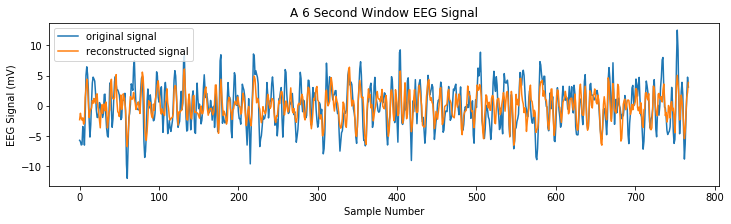

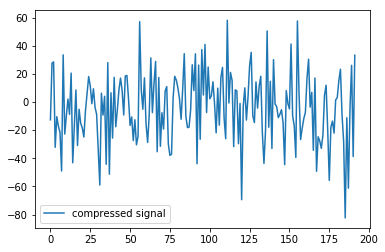

In [13]:
plt.figure(figsize=(12,3))
plt.plot(x, label='original signal')
plt.plot(x2, label='reconstructed signal')
plt.ylabel("EEG Signal (mV)")
plt.xlabel("Sample Number")
plt.title("A 6 Second Window EEG Signal")
plt.legend()

plt.figure()
plt.plot(y, label='compressed signal')
plt.legend()

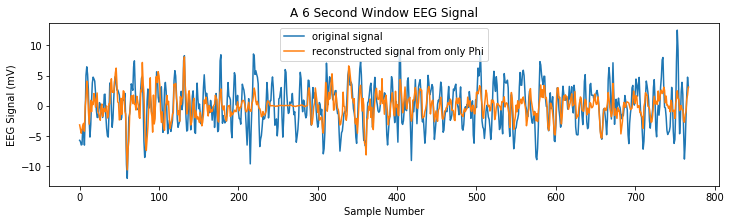

In [14]:
#reconstruction from just Phi?:
clf = bo(verbose=1, learn_type=1, learn_lambda=2,
         prune_gamma=-1, epsilon=1e-8, max_iters=16)
x3 = clf.fit_transform(Phi, y)

plt.figure(figsize=(12,3))
plt.plot(x, label='original signal')
plt.plot(x3, label='reconstructed signal from only Phi')
plt.ylabel("EEG Signal (mV)")
plt.xlabel("Sample Number")
plt.title("A 6 Second Window EEG Signal");
plt.legend()

In [15]:
mse_1 = 10*np.log10((lp.norm(x - x2)**2)/lp.norm(x)**2)
mse_2 = 10*np.log10((lp.norm(x - x3)**2)/lp.norm(x)**2)
print(mse_1, mse_2)

-2.8345593517792764 -1.8924521454552792


### Complete Compressive Sensing

In [16]:
M = 192
N = 768
p = 15/M

np.random.seed(3)
Phi = np.random.binomial(1, p, size = (M,N))

size = list(eeg_data.shape[0:4])
size.append(M)
y_all = np.zeros(tuple(size))

In [17]:
y_all.shape, eeg_data.shape, Phi.shape

((32, 40, 32, 10, 192), (32, 40, 32, 10, 768), (192, 768))

In [18]:
from datetime import datetime

In [19]:
start1 = datetime.now()
print('start compressing at '+start1.strftime("%H:%M:%S"))

for ind in range(eeg_data.shape[0]): 
    for vid in range(eeg_data.shape[1]):
        for sensor in range(eeg_data.shape[2]):
            for recording in range(eeg_data.shape[3]):
                x = eeg_data[ind,vid,sensor,recording,:]
                y_all[ind,vid,sensor,recording] = np.dot(Phi, x)

end1 = datetime.now()
print('end compressing at '+end1.strftime("%H:%M:%S"))

start compressing at 17:45:47
end compressing at 17:47:04


### Complete Signal Reconstruction

In [20]:
x_reconstructed = np.zeros(np.shape(eeg_data))

In [21]:
'''
#reconstruction:
#discrete cosine transform as dictionary (D) basis
#step 1: recover signal's coefficients in dct domain
A = np.zeros([M,N],dtype='float')
for k in range(M):
    dct_k = sf.dct(Phi[k,:].astype('float'),norm='ortho')
    A[k,:] = dct_k.copy()

clf = bo(verbose=1, learn_type=1, learn_lambda=2,
         prune_gamma=-1, epsilon=1e-8, max_iters=16)

start2 = datetime.now()
print('start reconstruction at '+start2.strftime("%H:%M:%S"))

for ind in range(eeg_data.shape[0]): 
    print("time "+datetime.now().strftime("%H:%M:%S"))
    print("starting individual "+str(ind))
    for vid in range(eeg_data.shape[1]):
        print("starting video "+str(vid))
        for sensor in range(eeg_data.shape[2]):
            print("starting sensor "+str(sensor))
            for recording in range(eeg_data.shape[3]):
                y = y_all[ind,vid,sensor,recording,:]
                rev_dct_coeff = clf.fit_transform(A, y)

                #step 2: recover the signal using the DCT ceofficients and the DCT basis
                x_reconstructed[ind,vid,sensor,recording] = sf.idct(rev_dct_coeff, norm='ortho')
                

end2 = datetime.now()
print('end reconstruction at '+end2.strftime("%H:%M:%S"))
'''

'\n#reconstruction:\n#discrete cosine transform as dictionary (D) basis\n#step 1: recover signal\'s coefficients in dct domain\nA = np.zeros([M,N],dtype=\'float\')\nfor k in range(M):\n    dct_k = sf.dct(Phi[k,:].astype(\'float\'),norm=\'ortho\')\n    A[k,:] = dct_k.copy()\n\nclf = bo(verbose=1, learn_type=1, learn_lambda=2,\n         prune_gamma=-1, epsilon=1e-8, max_iters=16)\n\nstart2 = datetime.now()\nprint(\'start reconstruction at \'+start2.strftime("%H:%M:%S"))\n\nfor ind in range(eeg_data.shape[0]): \n    print("time "+datetime.now().strftime("%H:%M:%S"))\n    print("starting individual "+str(ind))\n    for vid in range(eeg_data.shape[1]):\n        print("starting video "+str(vid))\n        for sensor in range(eeg_data.shape[2]):\n            print("starting sensor "+str(sensor))\n            for recording in range(eeg_data.shape[3]):\n                y = y_all[ind,vid,sensor,recording,:]\n                rev_dct_coeff = clf.fit_transform(A, y)\n\n                #step 2: recov

**Load reconstructed signal**

In [22]:
#load reconstructed signal from files
for i in range(x_reconstructed.shape[0]):
    filepath = os.path.join(os.getcwd(),'reconstructedData','ind'+str(i)+'.npy')
    ind_signal = np.load(filepath) #load individual's signal from file
    x_reconstructed[i] = ind_signal

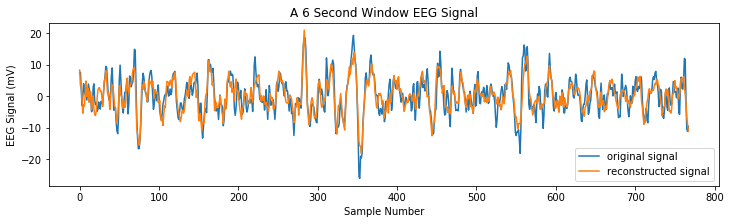

In [23]:
#check with random signal
plt.figure(figsize=(12,3))
plt.plot(eeg_data[7,10,22,5,:], label='original signal')
plt.plot(x_reconstructed[7,10,22,5,:], label='reconstructed signal')
plt.ylabel("EEG Signal (mV)")
plt.xlabel("Sample Number")
plt.title("A 6 Second Window EEG Signal");
plt.legend()

### Check features of compressed data

**Load compressed data**:

In [24]:
#load compressed signal from file (just to be 100% sure it pairs with the reconstruction)
y_compressed = np.zeros(np.shape(y_all))
for i in range(x_reconstructed.shape[0]):
    filepath = os.path.join(os.getcwd(),'compressedData','ind'+str(i)+'.npy')
    ind_signal = np.load(filepath) #load individual's signal from file
    y_compressed[i] = ind_signal

In [25]:
y_compressed.shape, y_compressed[0,0,:,:].shape

((32, 40, 32, 10, 192), (32, 10, 192))

In [26]:
y_compressed_reshape = np.reshape(y_compressed, (32, 40, 32, 192*10))
y_compressed_reshape.shape

(32, 40, 32, 1920)

### Check features of reconstructed data

In [27]:
def prd(x, x_reconstructed):
    return x

def sndr():
    return x

In [28]:
###TO DO:
#metrics for compressive sensing (used to measure the quality of signal reconstruction and amount of compression):
#compression ratio (CR = n/m)
print("compression ratio (CR): "+ str(N/M))
#percentage root-mean-squared difference (PRD)
print("percentage root-mean-squared difference (PRD): ")
#signal to noise and distortion ratio (SNDR)
print("signal to noise and distortion ratio (SNDR): ")
#percentage sparsity (PS)
print("percentage sparsity (PS): "+str(((N-p)/N)*100))

compression ratio (CR): 4.0
percentage root-mean-squared difference (PRD): 
signal to noise and distortion ratio (SNDR): 
percentage sparsity (PS): 99.98982747395834


In [30]:
x_reconstructed_reshape = np.reshape(x_reconstructed, (32, 40, 32, 7680))
x_reconstructed_reshape.shape

(32, 40, 32, 7680)

In [31]:
x_reconstructed.shape, eeg_data.shape

((32, 40, 32, 10, 768), (32, 40, 32, 10, 768))

In [32]:
## Feature Extraction

def get_signal_statistics(x):
    mean = np.mean(x)
    median = np.median(x)
    maximum = np.max(x)
    minimum = np.min(x)
    std = np.std(x)
    var = np.var(x)
    data_range = maximum - minimum
    skewness = scipy.stats.skew(x)
    kurtosis = scipy.stats.kurtosis(x)
    return [mean, median, maximum, minimum, std, var, data_range, skewness, kurtosis]

def encode_feature_vector(signal, vol_num, exp_num):
    features = []
    chunk_size = signal.shape[0] // 10
    for i in range(10):
        start = i * chunk_size
        end = (i+1) * chunk_size if i < 9 else signal.shape[0]
        data_chunk = signal[start:end]
        chunk_features = get_signal_statistics(data_chunk)
        features.extend(chunk_features)
    signal_features = get_signal_statistics(signal)
    features.extend(signal_features)
    features.extend([vol_num, exp_num])
    return features

feature_vector = encode_feature_vector(x_reconstructed_reshape[0,0,0,:], 0, 0)
len(feature_vector)

101

In [33]:
#grab features for NN

## Define Data Matrix and labels

#the paper seems slighty suspect, like they don't even remove the three second baseline?
supervised_data = np.zeros(shape = (1280,3232), dtype = np.float32)
supervised_labels = np.zeros(shape = (1280,), dtype = np.float32)

for vol_num in range(32):
    print(vol_num)
    for exp_num in range(40):
        vec = []
        for chan_num in range(32):
            features = encode_feature_vector(x_reconstructed_reshape[vol_num, exp_num, chan_num,:], vol_num, exp_num)
            vec.extend(features)
        idx = (vol_num * 40) + exp_num
        supervised_data[idx] = vec
        supervised_labels[idx] = int(labels[vol_num, exp_num, 0] >= 5) #the paper had 5 as the threshold

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [34]:
np.save("reconstructedFeatures.npy", supervised_data)
np.save("reconstructedLabels.npy", supervised_labels)

In [35]:
supervised_data.shape, supervised_labels.shape

((1280, 3232), (1280,))

### Compressed Domain Feature Extraction

In [36]:
#Need to create a new Phi based on identity matrix
np.random.seed(3)

ident = np.identity(N)
possible_indices = np.arange(N)
indices = np.random.choice(range(N), M, replace=False)
indices = np.sort(indices)

#create Phi based on selected indices--random rows of identity matrix
Phi = ident[indices]

size = list(eeg_data.shape[0:4])
size.append(M)
y_all = np.zeros(tuple(size))

In [37]:
Phi.shape, y_all.shape

((192, 768), (32, 40, 32, 10, 192))

In [38]:
start1 = datetime.now()
print('start compressing at '+start1.strftime("%H:%M:%S"))

for ind in range(eeg_data.shape[0]): 
    for vid in range(eeg_data.shape[1]):
        for sensor in range(eeg_data.shape[2]):
            for recording in range(eeg_data.shape[3]):
                x = eeg_data[ind,vid,sensor,recording,:]
                y_all[ind,vid,sensor,recording] = np.dot(Phi, x)

end1 = datetime.now()
print('end compressing at '+end1.strftime("%H:%M:%S"))

start compressing at 17:50:57
end compressing at 17:51:02


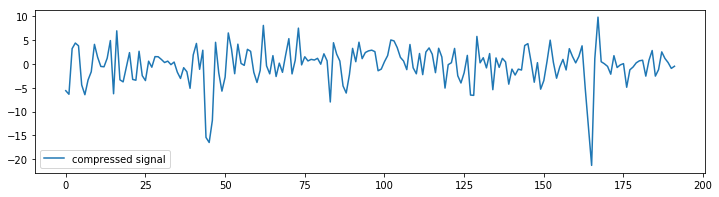

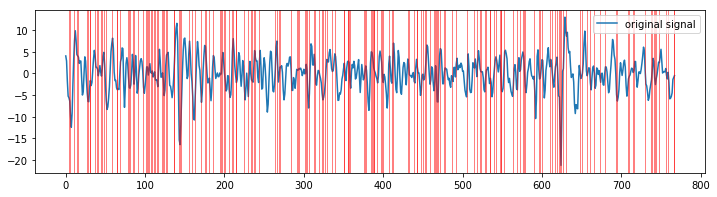

In [39]:
#visualize this random-sampling version of compression:
plt.figure(figsize=(12,3))
plt.plot(y_all[0,0,0,0,:], label='compressed signal')
plt.legend()

plt.figure(figsize=(12,3))
plt.plot(eeg_data[0,0,0,0,:], label='original signal')
for xc in indices: #plot locations of sampling
    plt.axvline(x=xc, color='red', linewidth=0.5, markersize=3)
plt.legend()

In [40]:
y_compressed_reshape = np.reshape(y_compressed, (32, 40, 32, 192*10))
y_compressed_reshape.shape

(32, 40, 32, 1920)

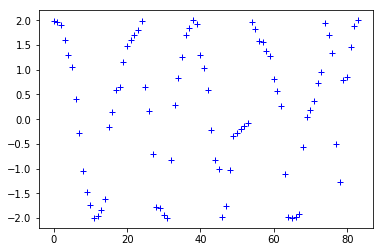

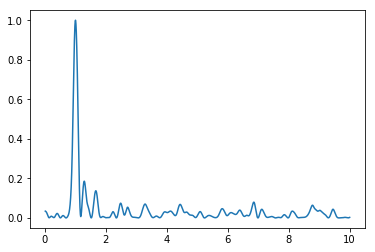

In [41]:
##Example of lomb-scargle periodogram
#from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
#also possibly helpful: https://medium.com/krakensystems-blog/spectral-analysis-of-irregularly-sampled-signal-37fc7f97062e
frac_points = 0.9 # Fraction of points to select
r = np.random.rand(1000)
x = np.linspace(0.01, 10*np.pi, 1000)
x = x[r >= frac_points]

phi = 0.5 * np.pi
y = 2. * np.sin(1.*x+phi)
plt.plot(y, 'b+')

f = np.linspace(0.01, 10, 100000)
pgram = signal.lombscargle(x, y, f, normalize=True)

plt.figure()
plt.plot(f, pgram)
plt.show()

In [42]:
frequency_bands = {'theta':(3.0,7.0), 'alpha':(8.0,13.0), 'beta':(14.0,29.0), 
                   'gamma':(30.0,47.0)}

Concept:

1. Estimate power spectrum density (periodogram) with Lomb-Scargle. The periodogram tells you how much power exists in the signal at each frequency. Make sure to normalize so you have the same amplitude as the original signal. 
2. For features, calculate the average spectral power within a corresponding frequency range. 

References (in order of utility of explanation): 
1. https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7921586 (A 172 µW Compressively Sampled Photoplethysmographic (PPG) Readout ASIC With Heart Rate Estimation Directly From Compressively Sampled Data)
2. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7370396 (A Novel Feature Extraction Algorithm for On the Sensor Node Processing of Compressive Sampled Photoplethysmography Signals)

**I would start with this article (3) to get an overview of the concept:**

For EEG-specific, there's a more recently (2020) updated/improved version of the original EEG LSP feature extraction (note: I have this downloaded if you have issues):
3. https://www.sciencedirect.com/science/article/abs/pii/S0010482520303358?via%3Dihub (Scalable and energy efficient seizure detection based on direct use of compressively-sensed EEG data on an ultra low power multi-core architecture)

The concept for EEG was originally found here (similar authorship, 2018), but their explanation is pretty weak. And the above version fills in some of the huge gaps about how they used LSP.
4. https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8514388 (Compressed Sensing Based Seizure Detection for an Ultra Low Power Multi-core Architecture)

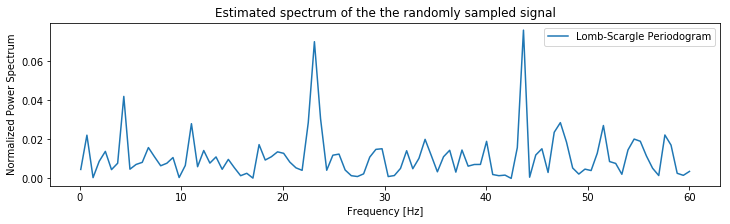

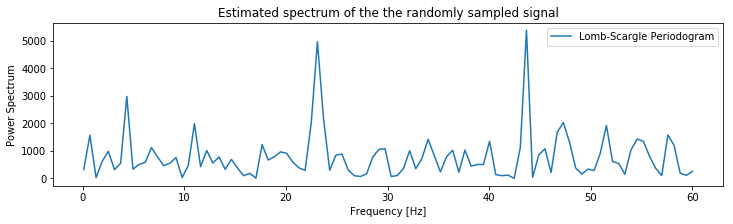

In [44]:
##I'm not sure this is correct... maybe the frequency needs to be something else?
t = indices #sampling instances are known: based on Phi
frequency = np.linspace(0.1, 60.0, 100) #DEAP should be between 4-45Hz
angular_frequency = 2*np.pi*frequency
periodogram = signal.lombscargle(t, y_compressed_reshape[0,0,0,0:192], angular_frequency, 
                                 precenter=True, normalize=True)
plt.figure(figsize=(12,3))
plt.plot(frequency, periodogram, label='Lomb-Scargle Periodogram')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Normalized Power Spectrum')
plt.title('Estimated spectrum of the the randomly sampled signal')
plt.legend()

periodogram_nonorm = signal.lombscargle(t, y_compressed_reshape[0,0,0,0:192], angular_frequency, 
                                        precenter=True)
plt.figure(figsize=(12,3))
plt.plot(frequency, periodogram_nonorm, label='Lomb-Scargle Periodogram')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectrum')
plt.title('Estimated spectrum of the the randomly sampled signal')
plt.legend()

In [45]:
#check PSD features
#note: I split the bands in half since the paper I'm basing it on paper that had 8 total sub-bands
print("low theta:", np.average(periodogram[(frequency >= 3) & (frequency <= 5)])) #low theta
print("high theta:", np.average(periodogram[(frequency >= 5) & (frequency <= 7)])) #high theta

print("low alpha:", np.average(periodogram[(frequency >= 7) & (frequency <= 10)])) #low alpha
print("high alpha:", np.average(periodogram[(frequency >= 10) & (frequency <= 13)])) #low alpha

print("low beta:", np.average(periodogram[(frequency >= 13) & (frequency <= 21.5)])) #low beta
print("high beta:", np.average(periodogram[(frequency >= 21.5) & (frequency <= 30)])) #high beta

print("low gamma:", np.average(periodogram[(frequency >= 30) & (frequency <= 38.5)])) #low gamma
print("high gamma:", np.average(periodogram[(frequency >= 38.5) & (frequency <= 47)])) #high gamma

low theta: 0.014745752540057751
high theta: 0.010395219481220139
low alpha: 0.007290175622862318
high alpha: 0.012559450377622839
low beta: 0.008074224109935305
high beta: 0.015124577236755619
low gamma: 0.00869275673949073
high gamma: 0.01318288272346733


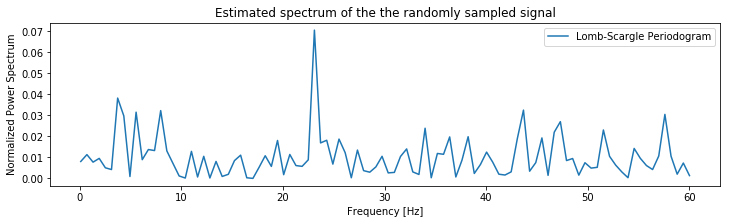

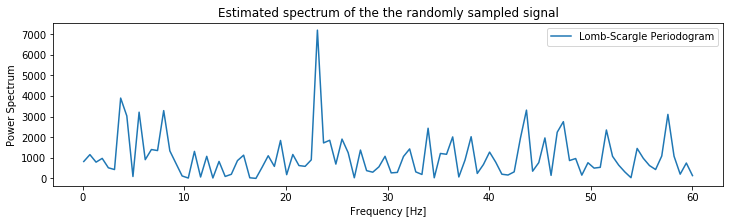

In [46]:
#test on second data point for check
t = indices #sampling instances are known: based on Phi
frequency = np.linspace(0.1, 60.0, 100) #DEAP should be meaningful between 4-45Hz
angular_frequency = 2*np.pi*frequency
periodogram = signal.lombscargle(t, y_compressed_reshape[0,0,10,0:192], angular_frequency, 
                                 precenter=True, normalize=True)
plt.figure(figsize=(12,3))
plt.plot(frequency, periodogram, label='Lomb-Scargle Periodogram')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Normalized Power Spectrum')
plt.title('Estimated spectrum of the the randomly sampled signal')
plt.legend()

periodogram_nonorm = signal.lombscargle(t, y_compressed_reshape[0,0,10,0:192], angular_frequency, 
                                        precenter=True)
plt.figure(figsize=(12,3))
plt.plot(frequency, periodogram_nonorm, label='Lomb-Scargle Periodogram')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectrum')
plt.title('Estimated spectrum of the the randomly sampled signal')
plt.legend()

In [47]:
t.shape, Phi.shape, (Phi.size - np.count_nonzero(Phi))/Phi.size #sparsity of Phi

((192,), (192, 768), 0.9986979166666666)

In [48]:
def get_signal_statistics(x):
    t = indices #sampling instances are known: based on Phi
    frequency = np.linspace(0.1, 60.0, 100) #DEAP should be meaningful between 4-45Hz
    angular_frequency = 2*np.pi*frequency
    periodogram = signal.lombscargle(t, x, angular_frequency, normalize=True)
    
    low_theta = np.average(periodogram[(frequency >= 3) & (frequency <= 5)]) #low theta
    high_theta = np.average(periodogram[(frequency >= 5) & (frequency <= 7)]) #high theta

    low_alpha = np.average(periodogram[(frequency >= 7) & (frequency <= 10)]) #low alpha
    high_alpha = np.average(periodogram[(frequency >= 10) & (frequency <= 13)]) #low alpha

    low_beta = np.average(periodogram[(frequency >= 13) & (frequency <= 21.5)]) #low beta
    high_beta = np.average(periodogram[(frequency >= 21.5) & (frequency <= 30)]) #high beta

    low_gamma = np.average(periodogram[(frequency >= 30) & (frequency <= 38.5)]) #low gamma
    high_gamma = np.average(periodogram[(frequency >= 38.5) & (frequency <= 47)]) #high gamma
    return [low_theta, high_theta, low_alpha, high_alpha, low_beta, high_beta, low_gamma, high_gamma]

def encode_feature_vector(signal, vol_num, exp_num):
    features = []
    chunk_size = signal.shape[0] // 10
    for i in range(10): #10 batches, 8 features from each
        start = i * chunk_size
        end = (i+1) * chunk_size if i < 9 else signal.shape[0]
        data_chunk = signal[start:end]
        chunk_features = get_signal_statistics(data_chunk)
        features.extend(chunk_features)
    #features.extend(signal_features)
    #features.extend([vol_num, exp_num])
    return features

In [49]:
test = get_signal_statistics(y_compressed_reshape[0,0,10,0:192])
test

[0.018479681365309395,
 0.017750620493369156,
 0.013507911163441777,
 0.004856035189031474,
 0.006496286811792366,
 0.014044696297141645,
 0.009324485130515118,
 0.009960147745422957]

In [51]:
supervised_data = np.zeros(shape = (1280,2560), dtype = np.float32) #32 individuals who watched 40 videos = 1280
for vol_num in range(32):
    print(vol_num)
    for exp_num in range(40):
        vec = []
        for chan_num in range(32):
            features = encode_feature_vector(y_compressed_reshape[vol_num, exp_num, chan_num,:], vol_num, exp_num)
            vec.extend(features)
        idx = (vol_num * 40) + exp_num
        supervised_data[idx] = vec

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [52]:
supervised_data.shape

(1280, 2560)